In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML('<style>.container { width:97% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

# MODEL 4
## Kernel: Spektral (200 epochs, 15 patience) + Vectorize vertex ( 8 bits)
## Supervised Autoencoder (100 epochs, my_Sinusoidal) (from 128 to 32)
## Supervised Autoencoder (100 epochs, my_Sinusoidal) (from 32 to 2)  
  
### My_Sinusoidal: plateau = 10, k = 1 , n_period = 4, scale_c = 0.001, scale_d = 0.1

In [3]:
import load_data as ld
import embedder_generator as gen
import embedder
import utilities as ut

from sklearn.model_selection import train_test_split

import keras.backend as K
from my_callbacks import MyCallback_sinusoidal
from sklearn.preprocessing import Normalizer

In [4]:
#name = "generate_graphs/125_pos_neg_BALANCED(2038)" #Leukemia
#name = "generate_graphs/489028_pos_neg_BALANCED(2864)" #Cancer
#name = "generate_graphs/1111_pos_neg_BALANCED" # AIDS
#name = "generate_graphs/2222_pos_neg_(BALANCED)" # PROTEINS
name = "generate_graphs/3333_pos_neg_(BALANCED)" # DHFR

In [6]:
# load data 
graphs,labels = ld.load_data_pubchem(name)


# add vectorize vertex 8 bit
graphs = ut.add_info_to_nodes(graphs,ut.vec_vertex,8)
max_n_nodes, n_attributes = ut.find_shapes(graphs)
print("n_ attributes: "+str(n_attributes))

#split train test
graphs_train, graphs_test, labels_train, labels_test = train_test_split(graphs, labels, test_size=0.2, random_state=42)


# build models
spk_cla,spk_emb = gen.gen_SpektralGNN_emb(n_classes=2,
                                            max_n_nodes = max_n_nodes,
                                            n_attributes = n_attributes,
                                            n_components= 128)

emb_spk = embedder.Kernel_GNN(classificator = spk_cla,
                              embedder = spk_emb,
                              batch_size = 32,
                              validation_split = 0.2,
                              epochs = 200,
                              patience = 20,
                              callbacks=None,
                              verbose=0)

# fit spk
emb_spk.fit(graphs_train,labels_train)

# transfrom train and test to n_componentes = 128
X_train = emb_spk.transform(graphs_train)
X_test = emb_spk.transform(graphs_test)

n_ attributes: 261
Stopped epoch:  96


In [7]:
ut.evaluate_emb_train_test(X_test,labels_test,X_train,labels_train)

DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.567    0.634


# FROM 128 TO 32

In [8]:
w_dec = K.variable(1)
w_cla = K.variable(1)
input_auto = len(X_train[0])
auto_epochs = 100
auto_plateau = 10
auto_k = 1
auto_n_period = 4
auto_scale_c = 0.001
auto_scale_d = 0.1

In [9]:
auto1, enc1 = gen.gen_sup_auto_callback(w_dec,w_cla,input_auto,embedding_size=32,n_classes=2)
# CALLBACK  
my_call_sin1 = MyCallback_sinusoidal(w_dec, w_cla, auto_epochs,auto_plateau,auto_k,auto_n_period,auto_scale_c,auto_scale_d)
# SCALER
scal1 = embedder.Preprocessing_scaler([0, 1])    
# NORMALIZER
norm1 = Normalizer(copy=True, norm='l2')

emb_auto1 = embedder.Transformer_sup_autoencoder(autoencoder = auto1,
                                                 encoder = enc1,
                                                 batch_size = 32,
                                                 validation_split = 0.2,
                                                 epochs = auto_epochs,
                                                 callbacks = [my_call_sin1],
                                                 verbose = 0,
                                                 normal = norm1,
                                                 scaler = scal1)


# fit
emb_auto1.fit(X_train,labels_train)

# transform
X32_train = emb_auto1.transform(X_train)
X32_test = emb_auto1.transform(X_test)
# evaluate
ut.evaluate_emb_train_test(X32_test,labels_test,X32_train,labels_train)

DIM: 32             TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.525    0.612


# FROM 32 TO 2

In [11]:
w_dec = K.variable(1)
w_cla = K.variable(1)
input_auto = len(X32_train[0])
auto_epochs = 100
auto_plateau = 10
auto_k = 1
auto_n_period = 4
auto_scale_c = 0.001
auto_scale_d = 0.1


In [12]:
auto2, enc2 = gen.gen_sup_auto_callback(w_dec,w_cla,input_auto,embedding_size=2,n_classes=2,classifier_penultimate_layer_size=15)
# CALLBACK  
my_call_sin2 = MyCallback_sinusoidal(w_dec, w_cla, auto_epochs,auto_plateau,auto_k,auto_n_period,auto_scale_c,auto_scale_d)
# SCALER
scal2 = embedder.Preprocessing_scaler([0, 1])    
# NORMALIZER
norm2 = Normalizer(copy=True, norm='l2')

emb_auto2 = embedder.Transformer_sup_autoencoder(autoencoder = auto2,
                                                 encoder = enc2,
                                                 batch_size = 32,
                                                 validation_split = 0.2,
                                                 epochs = auto_epochs,
                                                 callbacks = [my_call_sin2],
                                                 verbose = 0,
                                                 normal = norm2,
                                                 scaler = scal2)

emb_auto2.fit(X32_train,labels_train)

X2_train = emb_auto2.transform(X32_train)
X2_test = emb_auto2.transform(X32_test)

DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.501     0.61


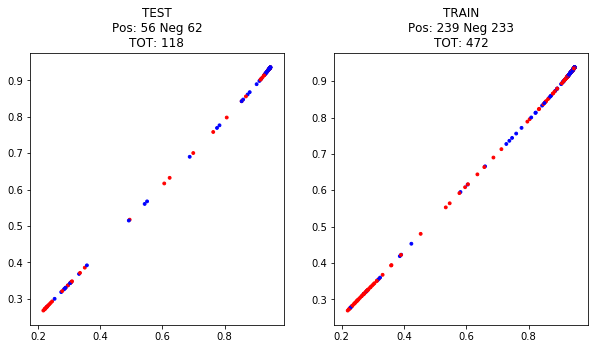

In [18]:
ut.evaluate_emb_train_test(X2_test,labels_test,X2_train,labels_train)

plot2d_tmp(X2_test,labels_test,X2_train,labels_train)

# Repeate the process 5 times
### Return (acc train/test dims: 128,32,2 - 5 embeddings 2d - 5 labels)

In [19]:
#name = "generate_graphs/125_pos_neg_BALANCED(2038)" #Leukemia
#name = "generate_graphs/489028_pos_neg_BALANCED(2864)" #Cancer
#name = "generate_graphs/1111_pos_neg_BALANCED" # AIDS
#name = "generate_graphs/2222_pos_neg_(BALANCED)" # PROTEINS
name = "generate_graphs/3333_pos_neg_(BALANCED)" # DHFR
n_bits = 8 #8
n_times = 5 #5

res = execute(name,n_bits,n_times,prot=False)

# Save results

In [19]:
np.save("Model4_res_prot",res_dhfr, allow_pickle=True)

# Used methods

In [14]:
import networkx as nx
def remove_big_graphs(graphs_in,labels_in):
    grpahs_in = np.array(graphs_in)
    print("sto eliminado i grafi grandi")
    graphs = []
    labels = []
    for j in range(len(graphs_in)):
        n_nodes = graphs_in[j].number_of_nodes() 
        if (n_nodes < 150):
            graphs.append(graphs_in[j])
            labels.append(labels_in[j])
    print(len(graphs))
    graphs = np.array(graphs)
    labels = np.array(labels)
    return(graphs,labels)

In [15]:
from sklearn.model_selection import StratifiedKFold
def execute(name,n_bits=8,n_times=5,prot=False):
    
    acc_128_test = []
    acc_128_train = []
    acc_32_test = []
    acc_32_train = []
    acc_2_test = []
    acc_2_train = []
    X2_test = []
    X2_train = []
    lab_test = []
    lab_train = []
    
    
    kFold = StratifiedKFold(n_splits=5)
    
    #print("TMP MUTAG")
    #graphs,labels = ld.load_data("MUTAG")
    graphs,labels = ld.load_data_pubchem(name)
    if (prot == True):
        print("removing_big_graphs")
        remove_big_graphs(graphs,labels)
        
    # add vectorize vertex 5 bit
    graphs = ut.add_info_to_nodes(graphs,ut.vec_vertex,n_bits)
    max_n_nodes, n_attributes = ut.find_shapes(graphs)
    print("n_ attributes: "+str(n_attributes))
    
    graphs = np.array(graphs)
    #split train test
    count = 0
    for train, test in kFold.split(graphs, labels):
        if (count == n_times):
            break
            
        graphs_train = graphs[train]
        graphs_test = graphs[test]
        labels_train = labels[train]
        labels_test = labels[test]
        
        acc_128_te,acc_128_tr,acc_32_te,acc_32_tr,acc_2_te,acc_2_tr,X2_te,X2_tr = run(graphs_train, graphs_test, labels_train, labels_test,max_n_nodes, n_attributes)
        
        acc_128_test.append(acc_128_te)
        acc_128_train.append(acc_128_tr)
        acc_32_test.append(acc_32_te)
        acc_32_train.append(acc_32_tr)
        acc_2_test.append(acc_2_te)
        acc_2_train.append(acc_2_tr)
        X2_test.append(X2_te)
        X2_train.append(X2_tr)
        lab_test.append(labels_test)
        lab_train.append(labels_train)
        
        count = count + 1
        
    return([acc_128_test,acc_128_train,acc_32_test,acc_32_train,acc_2_test,acc_2_train,X2_test,X2_train,lab_test,lab_train])

In [16]:
def run(graphs_train, graphs_test, labels_train, labels_test,max_n_nodes, n_attributes):
    


    # build models
    spk_cla,spk_emb = gen.gen_SpektralGNN_emb(n_classes=2,
                                                max_n_nodes = max_n_nodes,
                                                n_attributes = n_attributes,
                                                n_components= 128)

    emb_spk = embedder.Kernel_GNN(classificator = spk_cla,
                                  embedder = spk_emb,
                                  batch_size = 32,
                                  validation_split = 0.2,
                                  epochs = 200,
                                  patience = 20,
                                  callbacks=None,
                                  verbose=0)

    # fit spk
    emb_spk.fit(graphs_train,labels_train)

    # transfrom train and test to n_componentes = 128
    X_train = emb_spk.transform(graphs_train)
    X_test = emb_spk.transform(graphs_test)


    ut.evaluate_emb_train_test(X_test,labels_test,X_train,labels_train)
    acc_128_test, acc_128_train = ut.evaluate_emb_train_test(X_test,labels_test,X_train,labels_train,return_value=True)

    w_dec = K.variable(1)
    w_cla = K.variable(1)
    input_auto = len(X_train[0])
    auto_epochs = 100
    auto_plateau = 10
    auto_k = 1
    auto_n_period = 4
    auto_scale_c = 0.001
    auto_scale_d = 0.1

    auto1, enc1 = gen.gen_sup_auto_callback(w_dec,w_cla,input_auto,embedding_size=32,n_classes=2)
    # CALLBACK  
    my_call_sin1 = MyCallback_sinusoidal(w_dec, w_cla, auto_epochs,auto_plateau,auto_k,auto_n_period,auto_scale_c,auto_scale_d)
    # SCALER
    scal1 = embedder.Preprocessing_scaler([0, 1])    
    # NORMALIZER
    norm1 = Normalizer(copy=True, norm='l2')

    emb_auto1 = embedder.Transformer_sup_autoencoder(autoencoder = auto1,
                                                     encoder = enc1,
                                                     batch_size = 32,
                                                     validation_split = 0.2,
                                                     epochs = auto_epochs,
                                                     callbacks = [my_call_sin1],
                                                     verbose = 0,
                                                     normal = norm1,
                                                     scaler = scal1)


    # fit
    emb_auto1.fit(X_train,labels_train)


    # transform
    X32_train = emb_auto1.transform(X_train)
    X32_test = emb_auto1.transform(X_test)
    # evaluate
    ut.evaluate_emb_train_test(X32_test,labels_test,X32_train,labels_train)
    acc_32_test, acc_32_train = ut.evaluate_emb_train_test(X32_test,labels_test,X32_train,labels_train,return_value=True)

    w_dec = K.variable(1)
    w_cla = K.variable(1)
    input_auto = len(X32_train[0])
    auto_epochs = 100
    auto_plateau = 10
    auto_k = 1
    auto_n_period = 4
    auto_scale_c = 0.001
    auto_scale_d = 0.1


    auto2, enc2 = gen.gen_sup_auto_callback(w_dec,w_cla,input_auto,embedding_size=2,n_classes=2,classifier_penultimate_layer_size=15)
    # CALLBACK  
    my_call_sin2 = MyCallback_sinusoidal(w_dec, w_cla, auto_epochs,auto_plateau,auto_k,auto_n_period,auto_scale_c,auto_scale_d)
    # SCALER
    scal2 = embedder.Preprocessing_scaler([0, 1])    
    # NORMALIZER
    norm2 = Normalizer(copy=True, norm='l2')

    emb_auto2 = embedder.Transformer_sup_autoencoder(autoencoder = auto2,
                                                     encoder = enc2,
                                                     batch_size = 32,
                                                     validation_split = 0.2,
                                                     epochs = auto_epochs,
                                                     callbacks = [my_call_sin2],
                                                     verbose = 0,
                                                     normal = norm2,
                                                     scaler = scal2)

    emb_auto2.fit(X32_train,labels_train)

    X2_train = emb_auto2.transform(X32_train)
    X2_test = emb_auto2.transform(X32_test)

    ut.evaluate_emb_train_test(X2_test,labels_test,X2_train,labels_train)
    acc_2_test, acc_2_train = ut.evaluate_emb_train_test(X2_test,labels_test,X2_train,labels_train,return_value=True)
    
    
    acc_128_test = float(acc_128_test)
    acc_128_train = float(acc_128_train)
    acc_32_test = float(acc_32_test)
    acc_32_train = float(acc_32_train)
    acc_2_test = float(acc_2_test)
    acc_2_train = float(acc_2_train)
    
    return(acc_128_test,acc_128_train,acc_32_test,acc_32_train,acc_2_test,acc_2_train,list(X2_test),list(X2_train))



In [17]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
def plot2d_tmp(res_test,y_test,res_train,y_train):
    _,[pos_tra,neg_tra] = np.unique(y_train,return_counts=True)
    _,[pos_tes,neg_tes] = np.unique(y_test,return_counts=True)

    colors = ['red','blue']
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    x = res_test[:,0]
    y = res_test[:,1]
    plt.title("TEST\nPos: "+str(pos_tes)+" Neg "+str(neg_tes)+"\nTOT: "+str(len(y_test)))
    plt.scatter(x,y,s=8,c=y_test,cmap=matplotlib.colors.ListedColormap(colors))


    plt.subplot(122)
    x = res_train[:,0]
    y = res_train[:,1]
    plt.title("TRAIN\nPos: "+str(pos_tra)+" Neg "+str(neg_tra)+"\nTOT: "+str(len(y_train)))
    plt.scatter(x,y,s=8,c=y_train,cmap=matplotlib.colors.ListedColormap(colors))

    plt.show()
    
    
    